<a href="https://colab.research.google.com/github/gatienc/multimodal_product_data_classification/blob/main/notebooks/gatien_image_model_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameters



In [1]:
BATCH_SIZE=32

In [2]:
num_classes=27

In [3]:
train_percentage=0.80
test_percentage=0.10
valid_percentage=0.10

# Imports

In [4]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torchvision


from tqdm.auto import tqdm # for cool loading bar


from sklearn.metrics import f1_score

import zipfile
import os
import copy

import matplotlib.pyplot as plt




In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Datasets import
downlaod the datasets from google drive (if needed)

saves the dataeset in a temporary datasets folder

In [6]:
# mount the drive where your dataset is availabledevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from google.colab import drive
drive.mount('/content/drive')
filepath='/content/drive/MyDrive/datasets/multimodal_product_classification/' # add your own path. Where to save the dataset


Mounted at /content/drive


In [7]:
if not os.path.exists('datasets'):
  os.makedirs('datasets')
  with zipfile.ZipFile(filepath+'images.zip', 'r') as zip_ref:
      zip_ref.extractall('datasets')

In [8]:
class ImageDataLoader(torchvision.datasets.ImageFolder):
   def __init__(self, root, transform=None, target_transform=None):
       # Define the transformations
       self.transform = torchvision.transforms.Compose([
           torchvision.transforms.ToTensor(),
           torchvision.transforms.Normalize((0.5,), (0.5,))
       ])
       super().__init__(root, transform=self.transform, target_transform=target_transform)


In [9]:
dataset = ImageDataLoader('datasets/images/image_train')

In [10]:
train_size = int(train_percentage * len(dataset))
valid_size = int(test_percentage * len(dataset))
test_size = len(dataset) - train_size - valid_size

In [11]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

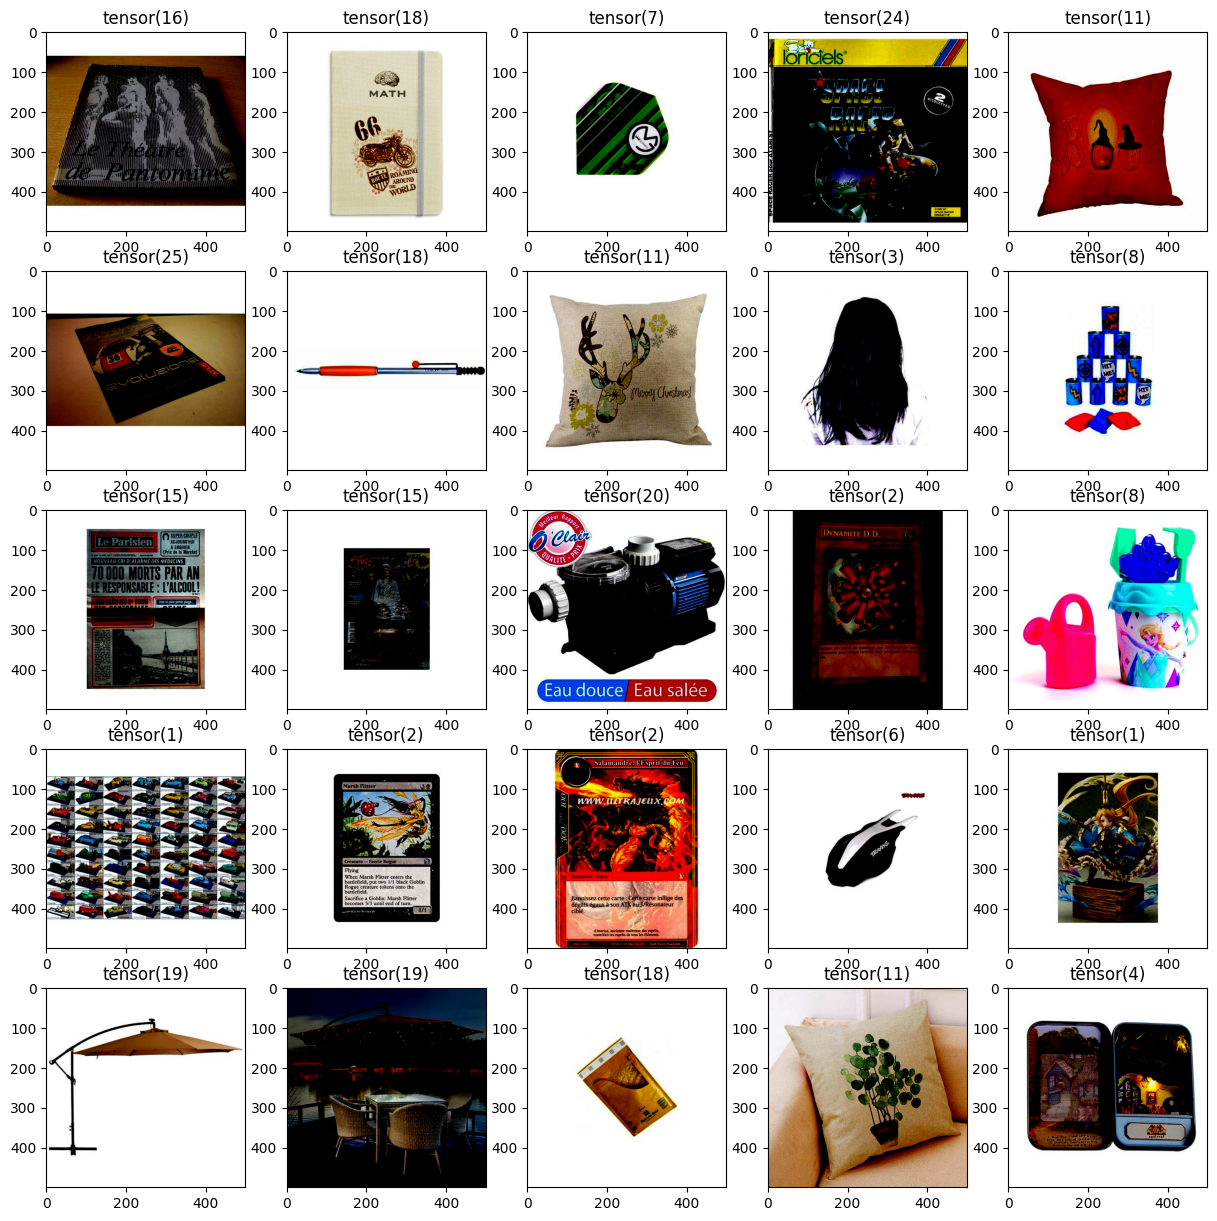

In [12]:
plt.figure(figsize=(15, 15))
for index, (images, labels) in enumerate(train_dataloader):
  for i in range(25):
   # Your training code here
    plt.subplot(5,5,i+1)
    plt.imshow(images[i].permute(1, 2, 0).numpy())
    plt.title(labels[i])
  break
plt.show()

# model definition


In [13]:
dataloaders={
    'train':train_dataloader,
    'val':valid_dataloader,
    'test':test_dataloader
    }

In [14]:
model = torchvision.models.resnet50(weights="IMAGENET1K_V2")

# Freeze parameters so we don't backprop through them
for param in model.parameters():
   param.requires_grad = False

# Replace the last fully-connected layer
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes) # num_classes is the number of classes in your dataset

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 121MB/s]


In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  epoch=0
  epoch_loss=0
  epoch_acc=0
  for epoch in tqdm(range(num_epochs),desc='Epoch {}/{}'.format(epoch, num_epochs - 1)):
      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':

              model.train() # Set model to training mode
          else:
              model.eval()  # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in tqdm(dataloaders[phase],desc='{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)):
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          if phase == 'train':
              scheduler.step()

          epoch_loss = running_loss / len(dataloaders[phase])
          epoch_acc = running_corrects.double() / len(dataloaders[phase])
          torch.save(model.state_dict(), '/content/drive/MyDrive/Lessons/Models/multimodal_classification/' + 'Image-epoch{:04}.ckpt'.format(epoch))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())


  print('Best val Acc: {:4f}'.format(best_acc))

   # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [ ]:
model=train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24:   0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.0000 Acc: 0.0000:   0%|          | 0/2123 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Lessons/Models/multimodal_classification/' + 'Resnet50-best.ckpt')
